# DMC 2022
### Predicting user-based replenishment of a product based on historical orders and item features 

## 1. Task

The participating teams’ goal is to predict the user-based replenishment of a product based on
historical orders and item features. Individual items and user specific orders are given for the period
between 01.06.2020 and 31.01.2021. The prediction period is between 01.02.2021 and 28.02.2021,
which is exactly four weeks long.
For a predefined subset of user and product combinations, the participants shall predict if and when
a product will be purchased during the prediction period.
The prediction column in the “submission.csv” file must be filled accordingly.
* 0 - no replenishment during that period
* 1 - replenishment in the first week
* 2 - replenishment in the second week
* 3 - replenishment in the third week
* 4 - replenishment in the fourth week

## 2. Problem Definition

The problem we will be exploring is **multiclass classification**. Based on a number of different features we are trying to predict whether a product will be replenished by a certain customer in a specific week 1-4 or not at all 0.

## 3. Tools we are going to use

* [pandas](https://pandas.pydata.org/) for data analysis and data manipulation
* [Knime](https://www.knime.com/) for data analysis (outside of this notebook)
* [NumPy](https://numpy.org/) for numerical operations
* [Matplotlib](https://matplotlib.org/) for visualization
* [Scikit-Learn](https://scikit-learn.org/stable/) for machine learning modeling and evaluation
* [XGBoost](https://xgboost.readthedocs.io/en/stable/) for gradient boosting
* [Hyperopt](http://hyperopt.github.io/hyperopt/) for hyper-parameter optimization

## 4. Features

1. date
2. userID
3. itemID
4. order
5. brand
6. feature_1
7. feature_2
8. feature_3
9. feature_4
10. feature_5
11. categories
12. week

#### Not used
13. RCP
14. parent_category

## Imports and Functions

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scipy as sc
import gc

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.tree import DecisionTreeClassifier

import hyperopt
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

def show_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

## Read data

In [2]:
file1 = r'E:\OneDrive\Arbeit\Repos\DMC2022\Kevin\csv\06_complete_dataset_labeled_week0.csv'

#file1 = r'E:\OneDrive\Arbeit\Repos\DMC2022\Kevin\csv\04_complete_dataset_labeled_wLastPurchaseDates_noOnetimers.csv'
df_data = pd.read_csv(file1, sep='|', dtype={'userID':np.uint32,
                                            'date':str, 
                                            'itemID':np.uint32,
                                            'order':np.uint8,
                                            'brand':np.uint16,
                                            'feature_1':np.uint8,
                                            'feature_2':np.uint8,
                                            'feature_3':np.uint16,
                                            'feature_4':np.uint8,
                                            'feature_5':np.uint16,
                                            'week':np.uint8})
                     #chunksize=10000)

show_mem_usage(df_data)
df_data.head(10)

Memory usage of dataframe is 35.70 MB


,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories,week
0,2020-06-01,38769,3477,1,186,6,0,196,0,45,"[74, 4109, 3867, 803, 4053]",0
1,2020-06-01,10318,4735,1,791,10,1,504,0,17,"[2459, 2197, 61, 3604, 1861, 3916]",0
2,2020-06-01,10318,20343,1,194,10,0,506,3,65535,"[826, 3755, 2041, 1546, 199, 2995, 871, 3702, ...",0
3,2020-06-01,10318,20672,1,963,10,0,507,3,123,"[806, 2091, 2073, 2304, 3976]",0
4,2020-06-01,10318,2918,1,441,10,0,507,0,39,"[2091, 2023]",0
5,2020-06-01,9217,1328,1,322,6,0,536,0,46,[2957],0
6,2020-06-01,9217,18630,1,6,4,0,291,0,44,"[2977, 30, 1515, 1760, 2932, 377, 3727, 747, 3...",0
7,2020-06-01,16731,3831,1,772,10,0,503,0,28,"[146, 308, 1760, 1694, 2863, 1138]",0
8,2020-06-01,8110,24623,1,504,10,0,441,3,84,"[3348, 2708]",0
9,2020-06-01,16731,5170,1,1010,10,0,522,0,17,"[2790, 1228, 517, 3580]",0


In [3]:
#df_data.drop('lastPurchaseDate', axis=1, inplace=True)
#df_data.drop('purchaseDates', axis=1, inplace=True)
df_data.head(10)

,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories,week
0,2020-06-01,38769,3477,1,186,6,0,196,0,45,"[74, 4109, 3867, 803, 4053]",0
1,2020-06-01,10318,4735,1,791,10,1,504,0,17,"[2459, 2197, 61, 3604, 1861, 3916]",0
2,2020-06-01,10318,20343,1,194,10,0,506,3,65535,"[826, 3755, 2041, 1546, 199, 2995, 871, 3702, ...",0
3,2020-06-01,10318,20672,1,963,10,0,507,3,123,"[806, 2091, 2073, 2304, 3976]",0
4,2020-06-01,10318,2918,1,441,10,0,507,0,39,"[2091, 2023]",0
5,2020-06-01,9217,1328,1,322,6,0,536,0,46,[2957],0
6,2020-06-01,9217,18630,1,6,4,0,291,0,44,"[2977, 30, 1515, 1760, 2932, 377, 3727, 747, 3...",0
7,2020-06-01,16731,3831,1,772,10,0,503,0,28,"[146, 308, 1760, 1694, 2863, 1138]",0
8,2020-06-01,8110,24623,1,504,10,0,441,3,84,"[3348, 2708]",0
9,2020-06-01,16731,5170,1,1010,10,0,522,0,17,"[2790, 1228, 517, 3580]",0


# Preprocessing

In [4]:
df_data = df_data.sort_values('date')
df_data.head(10)

,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories,week
0,2020-06-01,38769,3477,1,186,6,0,196,0,45,"[74, 4109, 3867, 803, 4053]",0
3394,2020-06-01,11575,3997,1,194,10,0,505,0,126,"[2060, 955, 2636, 3013, 293, 1578, 3446, 3915,...",0
3393,2020-06-01,27306,27936,1,618,4,0,323,0,144,"[30, 1763, 3915, 1060, 1525, 3914, 3444, 871]",0
3392,2020-06-01,2961,7021,1,1324,10,0,421,3,3,"[196, 3224, 2580, 2403, 2690, 3453, 3915, 3914]",1
3391,2020-06-01,16239,8526,1,322,6,0,536,0,46,[981],0
3390,2020-06-01,8542,25689,1,1180,1,1,522,3,9,"[2790, 871, 2417, 2454]",0
3389,2020-06-01,8001,2826,1,1111,10,0,487,0,1,"[1920, 2658]",0
3388,2020-06-01,38018,31702,3,703,10,0,345,0,97,"[3766, 2389, 3693, 1174, 3173, 3625, 2872, 391...",1
3387,2020-06-01,38018,20101,1,1090,10,1,502,0,185,"[2833, 498]",0
3386,2020-06-01,38018,29741,1,1496,10,0,287,3,87,"[2799, 3244]",0


### Multi-Hot-Encoding for categories

In contrast to One-Hot-Encoding where a column contains a single value which is converted to a one in the respective column, Multi-Hot-Encoding converts multiple entries in one cell to multiple ones in different columns. Therefore we first have to process the string in our category column, such that we can convert it into columns, without having duplicates.

#### Memory problem after Multi-Hot-Encoding
The problem we face when Multi-Hot-Encoding our categories is the following: After preprocessing and encoding we have 3.040.458.033 data points (904091 rows × 3363 columns). When trying to encode our categories with the str.get_dummies() method the size of the resulting dataframe is about ~30 GB depending on how many rows and features we are using. With a dataframe this big we run into memory problems when processing our data and building our model. 

#### Solution
There are are couple of different solutions to work around this problem. Normally we could work around memory limiations using batch processing or external memory. In case of the DMC dataset this is not optimal, since we need the whole customer history to make accurate predictions.

Since most of the colums we create from Multi-Hot-Encoding will be filled with zeros, we will be using a sparse matrix to significantly reduce the size of the resulting dataframe. The reduction we achieve with this approach results in dataframe size of 113 MB instead of ~30 GB.

In [5]:
# Convert strings to lists of integers in 'categories'
df_cat = df_data

df_cat["categories"] = df_cat["categories"].apply(lambda x: [int(i) for i in x[1:-1].split(',')])
df_cat["categories"]

0                                [74, 4109, 3867, 803, 4053]
3394       [2060, 955, 2636, 3013, 293, 1578, 3446, 3915,...
3393           [30, 1763, 3915, 1060, 1525, 3914, 3444, 871]
3392         [196, 3224, 2580, 2403, 2690, 3453, 3915, 3914]
3391                                                   [981]
                                 ...                        
1064543                                         [3639, 2667]
1064542                 [3005, 2152, 3646, 3667, 2711, 1427]
1064541                        [3224, 2580, 167, 1697, 2690]
1064539           [2826, 2256, 3915, 1518, 3914, 3924, 3912]
1069415             [2658, 2010, 1980, 1760, 2836, 332, 274]
Name: categories, Length: 1069416, dtype: object

In [6]:
# Multi-Hot-Encode columns with sparse output
c = df_cat["categories"]
mlb = MultiLabelBinarizer(sparse_output=False) # Set to True if output binary array is desired in CSR sparse format
df_multi_hot = pd.DataFrame(mlb.fit_transform(c), columns=mlb.classes_, index=None, dtype=np.int8)

show_mem_usage(df_multi_hot)

Memory usage of dataframe is 3420.66 MB


In [7]:
# Convert dataframe to sparse type
sparse_df_mh = df_multi_hot.astype(pd.SparseDtype("float64",0))
print(sparse_df_mh.info())
sparse_df_mh

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069416 entries, 0 to 1069415
Columns: 3354 entries, 0 to 4299
dtypes: Sparse[float64, 0](3354)
memory usage: 77.1 MB
None


,0,1,2,3,4,5,6,7,12,13,...,4287,4288,4289,4290,4292,4293,4294,4296,4298,4299
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1069412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1069413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1069414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
del df_multi_hot
gc.collect()

0

In [9]:
%%time

# Combine df_data and sparse_df_mh
df_combined = df_cat.join(sparse_df_mh, how='inner')
show_mem_usage(df_combined)
df_combined.head()

Memory usage of dataframe is 120.91 MB
CPU times: total: 2min 19s
Wall time: 2min 19s


,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,...,4287,4288,4289,4290,4292,4293,4294,4296,4298,4299
0,2020-06-01,38769,3477,1,186,6,0,196,0,45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3394,2020-06-01,11575,3997,1,194,10,0,505,0,126,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3393,2020-06-01,27306,27936,1,618,4,0,323,0,144,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3392,2020-06-01,2961,7021,1,1324,10,0,421,3,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3391,2020-06-01,16239,8526,1,322,6,0,536,0,46,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# pop and append 'week' at end of dataframe
col = df_combined.pop("week")
df_combined.insert(len(df_combined.columns), col.name, col)
df_combined.head()

,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,...,4288,4289,4290,4292,4293,4294,4296,4298,4299,week
0,2020-06-01,38769,3477,1,186,6,0,196,0,45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3394,2020-06-01,11575,3997,1,194,10,0,505,0,126,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3393,2020-06-01,27306,27936,1,618,4,0,323,0,144,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3392,2020-06-01,2961,7021,1,1324,10,0,421,3,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3391,2020-06-01,16239,8526,1,322,6,0,536,0,46,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [11]:
# Check if we have any missing values
df_combined[df_combined.isnull().any(axis=1)]

,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,...,4288,4289,4290,4292,4293,4294,4296,4298,4299,week


In [12]:
df_combined.drop('categories', axis=1, inplace=True)
show_mem_usage(df_combined)

Memory usage of dataframe is 112.75 MB


# Model

### Splitting Training- / Testdata

In [13]:
df = df_combined.copy()
id(df), id(df_combined)

(2681177554896, 2681178743008)

In [14]:
df.sort_values('date')

,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,...,4288,4289,4290,4292,4293,4294,4296,4298,4299,week
0,2020-06-01,38769,3477,1,186,6,0,196,0,45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2020-06-01,10318,4735,1,791,10,1,504,0,17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2020-06-01,10318,20343,1,194,10,0,506,3,65535,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2020-06-01,10318,20672,1,963,10,0,507,3,123,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2020-06-01,10318,2918,1,441,10,0,507,0,39,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069411,2021-01-31,38259,23411,1,1355,4,0,489,3,66,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1069412,2021-01-31,10236,6654,1,1496,10,0,359,0,97,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1069413,2021-01-31,21521,29277,1,127,10,0,519,0,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1069389,2021-01-31,30801,13274,1,1180,4,0,388,0,88,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [15]:
df.head()

,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,...,4288,4289,4290,4292,4293,4294,4296,4298,4299,week
0,2020-06-01,38769,3477,1,186,6,0,196,0,45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3394,2020-06-01,11575,3997,1,194,10,0,505,0,126,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3393,2020-06-01,27306,27936,1,618,4,0,323,0,144,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3392,2020-06-01,2961,7021,1,1324,10,0,421,3,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3391,2020-06-01,16239,8526,1,322,6,0,536,0,46,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [16]:
# Get index of first occurance of january date for split
idx = df.date.searchsorted('2021-01-01', side='left') # list needs to be sorted already for searchsorted
idx

904092

In [17]:
# check index
df['date'][idx], df['date'][idx - 1]

('2021-01-01', '2020-12-31')

In [18]:
# drop date
df.drop('date', axis=1, inplace=True)

In [19]:
# Comma is being used to extract a specific column from a 2D array.
# X = data.iloc[:,:-1]
# X = all rows, all columns except the last one 

X = df.iloc[:,0:-1]
X

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,0,...,4287,4288,4289,4290,4292,4293,4294,4296,4298,4299
0,38769,3477,1,186,6,0,196,0,45,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3394,11575,3997,1,194,10,0,505,0,126,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3393,27306,27936,1,618,4,0,323,0,144,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3392,2961,7021,1,1324,10,0,421,3,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3391,16239,8526,1,322,6,0,536,0,46,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1064543,13883,31520,1,1222,10,0,502,0,101,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1064542,463,19420,1,1037,10,0,395,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1064541,25672,11032,1,378,10,0,421,0,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1064539,10900,1841,1,1065,4,0,329,3,163,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
y = df.iloc[:,-1]
y

0          0
3394       0
3393       0
3392       1
3391       0
          ..
1064543    0
1064542    0
1064541    0
1064539    0
1069415    0
Name: week, Length: 1069416, dtype: uint8

In [21]:
# Split training/test data
# train = jun-dec20 / test = jan21

X_train = X.iloc[:idx-1]
X_test = X.iloc[idx:]
y_train = y.iloc[:idx-1]
y_test = y.iloc[idx:]

In [22]:
#X_test.sample(frac=1)

In [23]:
show_mem_usage(X_train), show_mem_usage(X_test)
X_train

Memory usage of dataframe is 88.15 MB
Memory usage of dataframe is 15.43 MB


,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,0,...,4287,4288,4289,4290,4292,4293,4294,4296,4298,4299
0,38769,3477,1,186,6,0,196,0,45,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3394,11575,3997,1,194,10,0,505,0,126,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3393,27306,27936,1,618,4,0,323,0,144,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3392,2961,7021,1,1324,10,0,421,3,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3391,16239,8526,1,322,6,0,536,0,46,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902666,24180,15121,1,598,4,1,491,0,66,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
902674,44390,6188,1,406,10,0,500,0,65535,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
902675,40416,26153,1,169,10,0,505,0,126,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
902676,16770,17053,4,829,10,0,510,0,29,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
y_train

0         0
3394      0
3393      0
3392      1
3391      0
         ..
902666    0
902674    0
902675    0
902676    4
902677    0
Name: week, Length: 904091, dtype: uint8

In [25]:
# Split training and test data
# parameter will preserve the proportion of target as in original dataset, in the train and test datasets as well.
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

#show_mem_usage(X_train), show_mem_usage(X_test)

# DecisionTreeClassifier

In [26]:
X_train

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,0,...,4287,4288,4289,4290,4292,4293,4294,4296,4298,4299
0,38769,3477,1,186,6,0,196,0,45,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3394,11575,3997,1,194,10,0,505,0,126,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3393,27306,27936,1,618,4,0,323,0,144,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3392,2961,7021,1,1324,10,0,421,3,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3391,16239,8526,1,322,6,0,536,0,46,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902666,24180,15121,1,598,4,1,491,0,66,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
902674,44390,6188,1,406,10,0,500,0,65535,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
902675,40416,26153,1,169,10,0,505,0,126,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
902676,16770,17053,4,829,10,0,510,0,29,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
y_test

905945     1
905930     1
905931     1
905932     1
905946     1
          ..
1064543    0
1064542    0
1064541    0
1064539    0
1069415    0
Name: week, Length: 165324, dtype: uint8

In [28]:
y

0          0
3394       0
3393       0
3392       1
3391       0
          ..
1064543    0
1064542    0
1064541    0
1064539    0
1069415    0
Name: week, Length: 1069416, dtype: uint8

In [29]:
"""
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
"""

'\nfrom sklearn.preprocessing import LabelEncoder\nle = LabelEncoder()\ny_train = le.fit_transform(y_train)\n'

In [30]:
y_train

0         0
3394      0
3393      0
3392      1
3391      0
         ..
902666    0
902674    0
902675    0
902676    4
902677    0
Name: week, Length: 904091, dtype: uint8

In [31]:
"""%%time

classifier = DecisionTreeClassifier()
classifier = classifier.fit(X_train,y_train)
"""

'%%time\n\nclassifier = DecisionTreeClassifier()\nclassifier = classifier.fit(X_train,y_train)\n'

In [32]:
"""y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

dct_train = accuracy_score(y_train, y_train_pred)
dct_test = accuracy_score(y_test, y_test_pred)
print()
print(f'Decision Tree train/test accuracies: '
     f'{dct_train:.3f}/{dct_test:.3f}')
"""

"y_train_pred = classifier.predict(X_train)\ny_test_pred = classifier.predict(X_test)\n\ndct_train = accuracy_score(y_train, y_train_pred)\ndct_test = accuracy_score(y_test, y_test_pred)\nprint()\nprint(f'Decision Tree train/test accuracies: '\n     f'{dct_train:.3f}/{dct_test:.3f}')\n"

In [33]:
#y_test_pred = list(y_test_pred)
#y_test2 = list(y_test)

In [34]:
#for i in range(len(y_test)):
#    print(y_test2[i],y_test_pred[i])

In [35]:
%%time

# Model with standard settings
model1 = XGBClassifier(tree_method='gpu_hist', gpu_id=0)
gbm = model1.fit(X_train, y_train)

y_train_pred = gbm.predict(X_train)
y_test_pred = gbm.predict(X_test)

xgb_train = accuracy_score(y_train, y_train_pred)
xgb_test = accuracy_score(y_test, y_test_pred)
print()
print(f'XGboost train/test accuracies: '
     f'{xgb_train:.3f}/{xgb_test:.3f}')


XGboost train/test accuracies: 0.730/0.736
CPU times: total: 12min 25s
Wall time: 4min 17s


<AxesSubplot:>

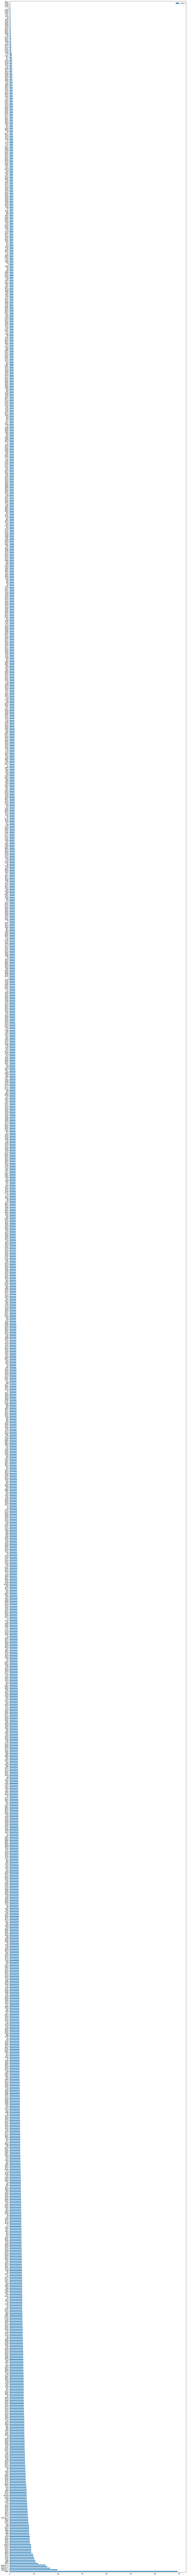

In [36]:
# ‘gain’: the average gain across all splits the feature is used in.
# https://xgboost.readthedocs.io/en/latest/python/python_api.html
feature_important = gbm.get_booster().get_score(importance_type='gain') # 'gbm' -> Model
keys = list(feature_important.keys())
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(2977, columns="score").plot(kind='barh', figsize = (20,300)) ## plot top 40 features

### Define domain space for range of values 

In [37]:
space = {'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

### Define objective function

In [38]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

### Minimize the objective over the space

In [39]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)

SCORE:                                                                                                                 
0.7358641213616898                                                                                                     
  2%|▉                                            | 1/50 [01:40<1:21:40, 100.00s/trial, best loss: -0.7358641213616898]


KeyboardInterrupt: 

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

In [ ]:
"""space = { 'eta': hp.quniform('eta', 0.025, 0.5, 0.05),
        'max_depth': hp.quniform("max_depth", 1, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }
"""

In [ ]:
"""
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators = space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }
"""

In [ ]:
"""
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)
"""

In [ ]:
!conda list

In [ ]:
!pip list